# Global map of drag coefficient

In [1]:
%matplotlib inline

import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from dask.distributed import Client
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from gsw import Nsquared, p_from_z, z_from_p
  
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34811,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:39721,Total threads: 1
Dashboard: /proxy/34375/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43591,


In [3]:
nx = 360
ny = 180
lat = np.full((ny),np.nan)
lon = np.full((nx),np.nan)
sigma_x = np.full((ny,nx),np.nan)
sigma_y = np.full((ny,nx),np.nan)
sigma_xy = np.full((ny,nx),np.nan)
depth_z = np.full((ny,nx),np.nan)

## Ocean depth

In [4]:
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')

def get_depth(lon,lat):
    return topog.z.interp(lat=lat,lon=lon).values

0.3.0


## Loop through tiles and re-construct drag coefficient arrays

In [5]:
for i in range(400):
    # print(i+1)
    filename = '/g/data/nm03/lxy581/global_drag_coeff/sigma_SAH_2d_%03d.nc' % (i+1)
    # print(filename)
    itile = xr.open_dataset(filename)

    # infer the lon & lat from itile
    ilon = i//20+1
    ilat = i+1 - (ilon-1)*20
    # print(ilon,ilat)
    
    lon[(ilon-1)*18:ilon*18] = itile.lon
    lat[(ilat-1)*9:ilat*9] = itile.lat
    sigma_x[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile.sigma_x
    sigma_y[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile.sigma_y    
    sigma_xy[(ilat-1)*9:ilat*9,(ilon-1)*18:ilon*18] = itile.sigma_xy

sigma = np.sqrt(sigma_x**2+sigma_y**2)

## Integrate drag coefficient along z-dir

In [6]:
for j in range(ny):
    for i in range(nx):
        depth_z[j,i] = get_depth(lon[i],lat[j])

In [7]:
depth_z[depth_z>0]=np.nan
depth_xr = xr.DataArray(depth_z, coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])
# depth_xr.plot()

In [8]:
sigma_x_xr  = xr.DataArray(sigma_x, coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])
sigma_y_xr  = xr.DataArray(sigma_y, coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])
sigma_xy_xr = xr.DataArray(sigma_xy, coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])
sigma_xr    = xr.DataArray(sigma, coords={'lat': lat, 'lon': lon}, dims=["lat", "lon"])

## Interpolate to remove the missing band near 180°

In [9]:
mask_array = ~np.isnan(np.array(sigma_x_xr))
ds = xr.Dataset(data_vars={
                'sigma_x_xr': (('lat','lon'), np.array(sigma_x_xr)),
                'sigma_y_xr': (('lat','lon'), np.array(sigma_y_xr)),
                'sigma_xy_xr': (('lat','lon'), np.array(sigma_xy_xr)),
                'sigma_xr': (('lat','lon'), np.array(sigma_xr)),
                'mask': (('lat','lon'), mask_array)
                }, 
                coords={'lon': sigma_x_xr.lon,'lat': sigma_x_xr.lat})
ds_out = xr.Dataset({"lat": (["lat"], lat[16:-16]),
                     "lon": (["lon"], lon),
                     "mask": (["lat","lon"], ~np.isnan(depth_z[16:-16,:]))})
regridder = xe.Regridder(ds, ds_out, "bilinear", extrap_method="inverse_dist")
ds_out = regridder(ds)

## Interpolate to 1/4° grid

In [10]:
ds_low = xr.Dataset(data_vars={
                               'sigma_x_25': (('lat','lon'), np.array(ds_out['sigma_x_xr'])),
                               'sigma_y_25': (('lat','lon'), np.array(ds_out['sigma_y_xr'])),
                               'sigma_xy_25': (('lat','lon'), np.array(ds_out['sigma_xy_xr'])),
                               'sigma_25': (('lat','lon'), np.array(ds_out['sigma_xr'])),
                               'mask': (('lat','lon'), ~np.isnan(depth_z[16:-16,:]))
                               }, 
                    coords={'lon': ds_out['lon'],'lat': ds_out['lat']})
ds_high = xr.Dataset({"lat": (["lat"], np.arange(-75,75+0.25,0.25)),
                      "lon": (["lon"], np.arange(-180,180+0.25,0.25)),
                     })
regridder2 = xe.Regridder(ds_low, ds_high, "bilinear", extrap_method="inverse_dist")
ds_high = regridder2(ds_low)

## Plot drag coefficient (x-dir, y-dir, magnitude)

In [17]:
def plot_global(lon,lat,sigma,dir,vmin,vmax):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, sigma, transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title('Internal tide drag coefficient (%s)' % dir)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma$ (m s$^{-1}$)');
    return 

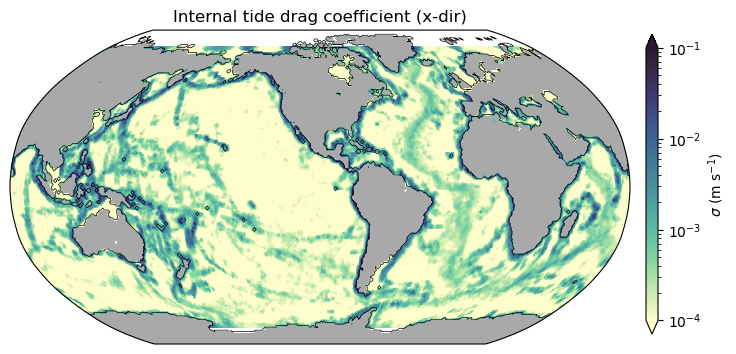

In [24]:
plot_global(ds_high['lon'],ds_high['lat'],ds_high['sigma_x_25'],'x-dir',1e-4,1e-1)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_x_025.png', dpi=300, bbox_inches='tight')

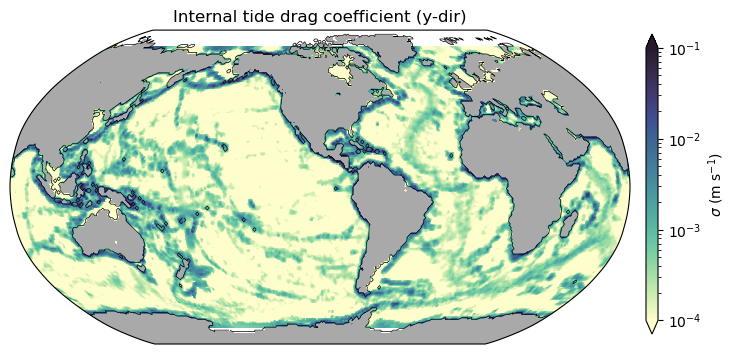

In [25]:
plot_global(ds_high['lon'],ds_high['lat'],ds_high['sigma_y_25'],'y-dir',1e-4,1e-1)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_y_025.png', dpi=300, bbox_inches='tight')

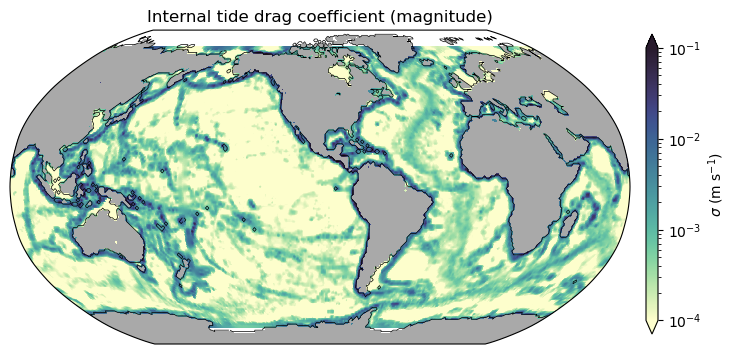

In [26]:
plot_global(ds_high['lon'],ds_high['lat'],ds_high['sigma_25'],'magnitude',1e-4,1e-1)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_mag_025.png', dpi=300, bbox_inches='tight')

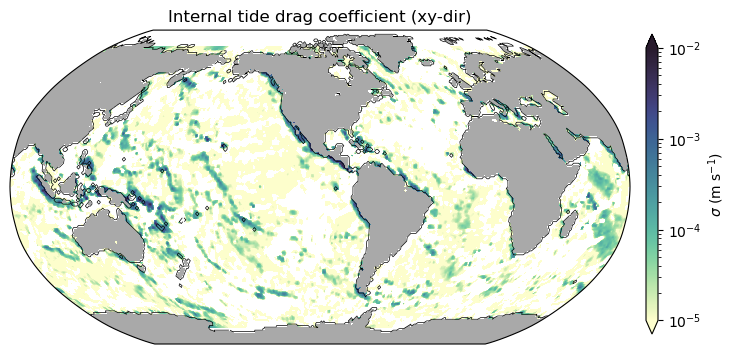

In [27]:
plot_global(ds_high['lon'],ds_high['lat'],ds_high['sigma_xy_25'],'xy-dir',1e-5,1e-2)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_xy_025.png', dpi=300, bbox_inches='tight')

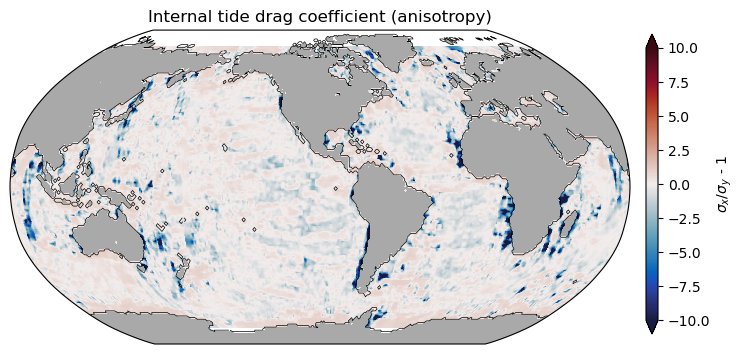

In [28]:
anisotropy = ds_high['sigma_x_25']/ds_high['sigma_y_25']-1

def plot_global_ratio(lon,lat,anisotropy,dir,vmin,vmax):
    fig = plt.figure(figsize=(8, 6))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land = xr.where(np.isnan(depth_xr[:,:].rename('land')), 1, np.nan)
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    p1 = ax1.pcolormesh(lon, lat, anisotropy, transform=ccrs.PlateCarree(), cmap=cm.cm.balance, vmin=vmin, vmax=vmax)
    plt.title('Internal tide drag coefficient (%s)' % dir)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel(r'$\sigma_x / \sigma_y$ - 1');
    return 

plot_global_ratio(ds_high['lon'],ds_high['lat'],-anisotropy,'anisotropy',-10,10)
plt.savefig('/g/data/nm03/lxy581/global_drag_coeff/drag_coeff_SAH_anisotropy_025.png', dpi=300, bbox_inches='tight')

### In the case of isotropic topography, $\sigma_x$ = $\sigma_y$, anisotropy defined here ($\sigma_x$/$\sigma_y$-1) would be 0. The dark red/blue colors indicate the regions where the topography is highly anisotropic.